# Image Classification with MNIST

## Import Libraries

In [1]:
from darwin.networks import EchoStateNetwork
from darwin.activations import fast_sigmoid_activation

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from qkeras.quantizers import quantized_relu

%matplotlib inline

## MNIST Dataset Preparation

In [2]:
num_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Generate the Echo State Network

In [3]:
nodes = 150
esn = EchoStateNetwork(
    n_inputs=X_train.shape[1],
    n_outputs=num_classes,
    n_neurons=nodes,
    sparsity=0.8,
    spectral_radius=0.45,
    activation=fast_sigmoid_activation,
    nbit_quant=6,
    readout_layer= {
        'type': 'MultiLayerDense',
        'hyper_params': {
            'layers': [
                {'units': 80, 'activation': quantized_relu},
                {'units': num_classes, 'activation': 'softmax'}
            ],
            'optimizer': tf.keras.optimizers.SGD(lr=0.1, momentum=0.000005, nesterov=True),
            'loss': tf.keras.losses.categorical_crossentropy,
            'metrics': ['accuracy'],
        }
    },
    seed=0
)

/Users/valerio/miniconda3/envs/test/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-01-27 17:33:33.998954: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the Readout Layer

In [4]:
history = esn.fit(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    batch_size=32,
    epochs=10
    )

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5619 - accuracy: 0.8668 - val_loss: 0.3882 - val_accuracy: 0.9141
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3714 - accuracy: 0.9195 - val_loss: 0.3524 - val_accuracy: 0.9248
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3291 - accuracy: 0.9322 - val_loss: 0.3220 - val_accuracy: 0.9356
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3072 - accuracy: 0.9391 - val_loss: 0.3084 - val_accuracy: 0.9397
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2947 - accuracy: 0.9430 - val_loss: 0.2953 - val_accuracy: 0.9416
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2841 - accuracy: 0.9476 - val_loss: 0.2983 - val_accuracy: 0.9436
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2776 - accuracy: 0.9500 - val_loss: 0.2937 - val_accuracy:

## Print Validation Accuracy

In [5]:
val_accuracy = history.history['val_accuracy'][-1] * 100
print(f'Validation accuracy: {val_accuracy:.2f}%')

Validation accuracy: 94.48%


## Let's Predict an Image

In [6]:
img_idx = 897 # Index number of an image in the test set

pred_proba = esn.predict(X_test[img_idx].reshape(1, -1))
pred_label = np.argmax(pred_proba)

print(f'Predicted label: {pred_label}')
print(f'Actual label: {np.argmax(y_test[img_idx])}')

Predicted label: 5
Actual label: 5


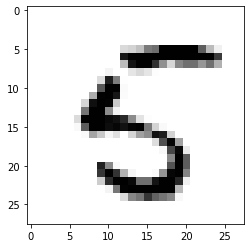

In [7]:
plt.imshow(X_test[img_idx].reshape(28, 28), cmap='Greys')